# Bayesian sampling of the posterior distribution

Part 2: realistic case (RNA oligomers)

In [1]:
import os, pandas
import numpy as np
import matplotlib, matplotlib.pyplot as plt

In [2]:
import sys, jax.numpy as jnp
sys.path.append('../../')

from MDRefine.MDRefine import load_data, normalize_observables, minimizer, unwrap_2dict, loss_function
from Functions.basic_functions_bayesian import local_density
from Functions.basic_functions_bayesian import compute, compute_single, run_Metropolis

In [3]:
dir_name = 'Manuscript_images'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [4]:
alpha = 10 # 0.5

## 2a. limited n. of observables

### 1. Load data

In [36]:
infos = {'global': {
    'path_directory': '../DATA/',
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J'],  # , 'NOEs'],# , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
    # 'obs': ['NOEs'],#, 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 1

In [37]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        s + '_3J' : fm_coeffs[0]*forward_qs_cos[s]**2 + fm_coeffs[1]*forward_qs_cos[s] + fm_coeffs[2] for s in forward_qs_cos.keys()}
    
        # that is:
        # 'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        # 'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        # 'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [38]:
infos['global']['forward_model'] = forward_model_fun

In [39]:
infos['global']['names_ff_pars'] = ['sin alpha']  # , 'cos alpha']

def ff_correction(pars, f):
    # out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    out = jnp.matmul(pars, (f[:, [0]] + f[:, [1]] + f[:, [2]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [40]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
done


### 2. normalize observables and find the optimal solution at given $\alpha$

In [12]:
name_mol = 'AAAA'

normalization: just once, at the beginning of Metropolis sampling

in order to simplify a (global) pre-factor in the Jeffreys prior

In [13]:
out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

data.mol[name_mol].g = out[0]
data.mol[name_mol].gexp = out[1]
data.mol[name_mol].normg_mean = out[2]
data.mol[name_mol].normg_std = out[3]

In [14]:
result = minimizer(data, alpha=alpha)  # this will be used in the next section, n.3

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

In [15]:
print(vars(result).keys())

result.min_lambdas

dict_keys(['loss', 'min_lambdas', 'minis', 'time', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])


{'AAAA': {'backbone1_gamma_3J': Array([-0.10733574,  0.01200342, -0.00399355,  0.08602784, -0.0013408 ,
         -0.00052592,  0.05354928, -0.00158434], dtype=float64),
  'backbone2_beta_epsilon_3J': Array([-0.31177294, -0.07640245,  0.00960209, -0.31266664, -0.02476925,
          0.01154571, -0.30598831, -0.06952945,  0.04570748], dtype=float64),
  'sugar_3J': Array([0.26537005, 0.07226732, 0.37331595, 0.1377446 , 0.05265389,
         0.19512567, 0.11616989, 0.03585691, 0.14768975, 0.26017004,
         0.12360601], dtype=float64)}}

### 3. try with just 2 observables to make a 2d plot

In [ ]:
assert list(data.mol.keys()) == ['AAAA'], 'ensure you have loaded just AAAA molecule'

s = 'backbone1_gamma_3J'
my_mol = data.mol['AAAA']
# to avoid repeating `data.mol['AAAA']` you can act on `my_mol`, with the same results on `data.mol['AAAA']`
# because this does not create a copy, just a reference to the original object!

assert s in list(my_mol.g.keys()), 'ensure you have loaded just one kind of observables'

my_mol.gexp = {s: my_mol.gexp[s]}
my_mol.g = {s: my_mol.g[s]}
my_mol.names = {s: my_mol.names[s]}
my_mol.ref = {s: my_mol.ref[s]}
my_mol.forward_qs = {s[:-3]: my_mol.forward_qs[s[:-3]]}
my_mol.n_experiments = {s: my_mol.n_experiments[s]}

In [44]:
my_mol.gexp[s] = my_mol.gexp[s][:2, :]
my_mol.g[s] = my_mol.g[s][:, :2]
my_mol.names[s] = my_mol.names[s][:2]
# my_mol.normg_mean[s] = my_mol.normg_mean[s][:2]
# my_mol.normg_std[s] = my_mol.normg_std[s][:2]
my_mol.n_experiments[s] = 2

In [19]:
out = minimizer(data, alpha=alpha)

vars(out)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

{'loss': Array(0.38558791, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': Array([-0.10907894,  0.00560952], dtype=float64)}},
 'minis': {'AAAA':   message: Optimization terminated successfully.
    success: True
     status: 0
        fun: -0.03855879115833204
          x: [-1.091e-01  5.610e-03]
        nit: 4
        jac: [ 5.488e-06  6.417e-07]
   hess_inv: [[ 1.533e-01  9.615e-03]
              [ 9.615e-03  1.961e-01]]
       nfev: 7
       njev: 7},
 'time': 1.3400559425354004,
 'D_KL_alpha': {'AAAA': Array(0.0073372, dtype=float64)},
 'abs_difference': {'AAAA': Array(2.92468827e-11, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': Array([ 0.12683122, -0.03972899], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': Array(0.62443189, dtype=float64)}},
 'logZ_new': {'AAAA': Array(0.00672028, dtype=float64)},
 'weights_new': {'AAAA': Array([1.04861414e-06, 9.68633665e-07, 1.08571261e-06, ...,
         8.59621583e-07, 9.00186147e-07, 8.90233189e-07], 

In [20]:
def flat_lambda(lambdas):

    flatten_lambda = []
    for name_mol in data.properties.system_names:
        flatten_lambda = flatten_lambda + list(
            np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

    flatten_lambda = np.array(flatten_lambda)

    return flatten_lambda

x_min = flat_lambda(out.min_lambdas)

print(x_min)

[-0.10907894  0.00560952]


In [21]:
n = 30
delta = 1

x = np.linspace(x_min[0] - delta, x_min[0] + delta, n)
y = np.linspace(x_min[1] - delta, x_min[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [22]:
sh = grid.shape

grid_vals_noJ = np.zeros(sh)
grid_vals_J = np.zeros(sh)
grid_vals_Dir = np.zeros(sh)

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.zeros(2), data, regularization=None, alpha=alpha, fixed_lambdas=np.array([x[i], y[j]]), if_save=True)
        grid_vals_noJ[i, j] = out.loss_explicit

        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)

        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol], which_measure='dirichlet')
        grid_vals_Dir[i, j] = grid_vals_noJ[i, j] - np.log(measure)


min:  0.16802887360397545
0.39625445819557276 28.87362873494827


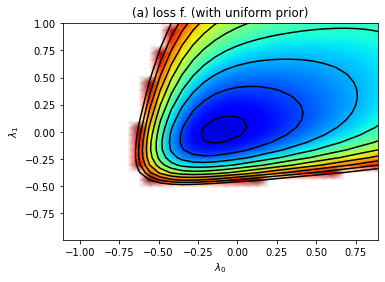

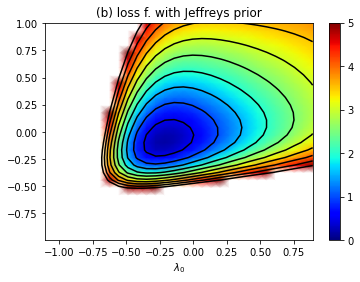

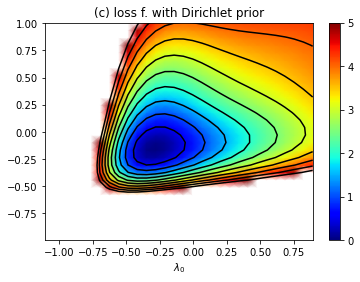

In [23]:
# matplotlib.rcParams['pcolor.shading']
# plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15
# plt.rcParams.update({'figure.autolayout': True})

print('min: ', np.min(grid_vals_J))

vmin = 0.
vmax = 5.
levels = np.linspace(vmin, vmax, 11)

cmap = plt.get_cmap('jet').copy()
cmap.set_over('white')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

plt.figure(figsize=(5.65, 4))
plt.pcolormesh(x, y, grid_vals_noJ, cmap=cmap, norm=norm, shading='gouraud')
# plt.colorbar()
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.title('(a) loss f. (with uniform prior)')
plt.contour(x, y, grid_vals_noJ, colors='k', levels=levels, linewidths=1.5)
plt.xlim()
# plt.savefig('Manuscript_images/ex2_plain_loss_contour.pdf', format='pdf', bbox_inches='tight')

plt.figure(figsize=(6, 4))
plt.pcolormesh(x, y, grid_vals_J, cmap=cmap, norm=norm, shading='gouraud')
plt.colorbar()
plt.xlabel('$\lambda_0$')
# plt.ylabel('$\lambda_1$')
plt.title('(b) loss f. with Jeffreys prior')
plt.contour(x, y, grid_vals_J, colors='k', levels=levels, linewidths=1.5)
# plt.savefig('Manuscript_images/ex2_Jeffreys_loss_contour.pdf', format='pdf', bbox_inches='tight')

grid_vals_Dir -= np.min(grid_vals_Dir)

vmin = 0
vmax = 5
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
levels = np.linspace(vmin, vmax, 11)

plt.figure(figsize=(6, 4))
plt.pcolormesh(x, y, grid_vals_Dir, cmap=cmap, norm=norm, shading='gouraud')
plt.colorbar()
plt.xlabel('$\lambda_0$')
# plt.ylabel('$\lambda_1$')
plt.title('(c) loss f. with Dirichlet prior')

plt.contour(x, y, grid_vals_Dir, colors='k', levels=levels, linewidths=1.5)
# plt.savefig('Manuscript_images/ex2_Jeffreys_loss_contour.pdf', format='pdf', bbox_inches='tight')


print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))

In [24]:
from Functions.basic_functions_gaussian import numerical_props

In [25]:
n_frames = len(data.mol['AAAA'].weights)
g = data.mol['AAAA'].g['backbone1_gamma_3J']
g_sigma_exp = data.mol['AAAA'].gexp['backbone1_gamma_3J']

num_props = numerical_props(n_frames, g, g_sigma_exp[:, 0], g_sigma_exp[:, 1], alpha)

num_props

           dV: 62.121112128763706
            g: Array([[ 0.60635112, -0.10018935,  0.92491837, ..., -0.96502621,
                       -0.72472794, -0.81477021],
                      [-0.87470658, -0.47012086, -0.87794185, ...,  3.9970593 ,
                        0.44990568,  0.68101606]], dtype=float64)
     lim_chi2: Array(1.95503364, dtype=float64)
      lim_dkl: Array(6.15291832, dtype=float64)
        lim_g: Array([-0.20683824, -0.95617641], dtype=float64)
 lim_loss_num: 62.506700040370866
        lim_p: Array([9.46550834e-022, 4.33256562e-108, 9.88613683e-022, ...,
                      0.00000000e+000, 0.00000000e+000, 0.00000000e+000], dtype=float64)
      min_avg: array([ 0.12683234, -0.03972907])
   min_lambda: array([-0.10907985,  0.0056093 ])
     min_loss: 0.3855879116071595
         mini:   message: Optimization terminated successfully.
                 success: True
                  status: 0
                     fun: 0.3855879116071595
                       x: [-1

In [26]:
print(num_props.dV)

62.121112128763706


### 4. sampling

- start sampling from the point of minimum

In [27]:
out = minimizer(data, alpha=1)

vars(out)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

{'loss': Array(0.12961296, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': Array([-0.33843236, -0.03393334], dtype=float64)}},
 'minis': {'AAAA':   message: Optimization terminated successfully.
    success: True
     status: 0
        fun: -0.1296129576073098
          x: [-3.384e-01 -3.393e-02]
        nit: 4
        jac: [-2.823e-04  2.730e-04]
   hess_inv: [[ 3.963e-01  1.998e-02]
              [ 1.998e-02  8.157e-01]]
       nfev: 6
       njev: 6},
 'time': 0.3011341094970703,
 'D_KL_alpha': {'AAAA': Array(0.09946902, dtype=float64)},
 'abs_difference': {'AAAA': Array(1.66054082e-07, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': Array([ 0.52113274, -0.07729896], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': Array(0.0602882, dtype=float64)}},
 'logZ_new': {'AAAA': Array(0.07427615, dtype=float64)},
 'weights_new': {'AAAA': Array([1.08805735e-06, 8.68495085e-07, 1.21178871e-06, ...,
         7.54201447e-07, 7.25323262e-07, 7.09092910e-07], d

In [28]:
def flat_lambda(lambdas):

    flatten_lambda = []
    for name_mol in data.properties.system_names:
        flatten_lambda = flatten_lambda + list(
            np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

    flatten_lambda = np.array(flatten_lambda)

    return flatten_lambda

x_min = flat_lambda(out.min_lambdas)

print(x_min)

[-0.33843236 -0.03393334]


In [29]:
def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_move = lambda x : proposal(x, 0.2)

# proposal_move = 'one-by-one'

def energy_fun(lambdas, if_Jeffreys):
    
    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=lambdas, if_save=True)
    
    """ vars(out).keys() = ['loss', 'loss_explicit', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2',
            'logZ_new', 'weights_new'] """
    
    energy = out.loss_explicit

    # quantities = 

    av_g = unwrap_2dict(out.av_g)[0]

    if if_Jeffreys:
        name_mol = list(out.weights_new.keys())[0]
        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])
        energy -= np.log(measure)
    
    return energy, av_g

In [30]:
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def my_energy_fun(x0, if_Jeffreys):
    with suppress_stdout():
        return energy_fun(x0, if_Jeffreys)

In [31]:
x0 = x_min
# x0 = .5*np.ones(2)

In [28]:
energy_function = lambda x0 : my_energy_fun(x0, False)
sampling_noJ = run_Metropolis(x0, proposal_move, energy_function, n_steps=int(2e4))

 67%|██████▋   | 13469/20000 [29:32<14:19,  7.60it/s] 


KeyboardInterrupt: 

about 70 iterations per sec.

In [44]:
energy_function = lambda x : my_energy_fun(x, True)
sampling_J = run_Metropolis(x0, proposal_move, energy_function, n_steps=int(2e4))


100%|██████████| 20000/20000 [1:03:59<00:00,  5.21it/s]


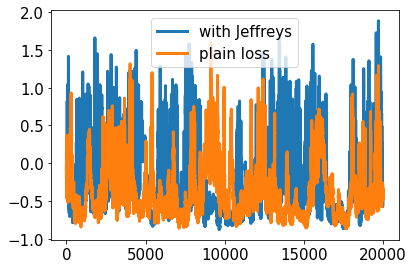

In [45]:
plt.plot(sampling_J[3][:, 1], label='with Jeffreys')
plt.plot(sampling_noJ[3][:, 1], label='plain loss')
plt.legend()

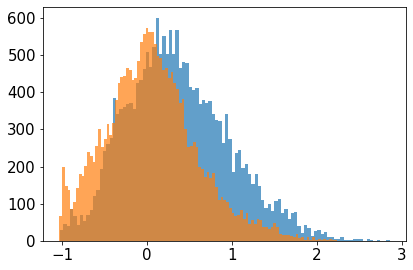

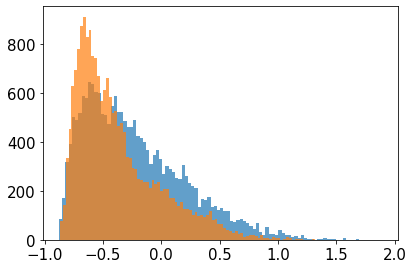

In [46]:
for i in range(sampling_J[3].shape[1]):
    plt.figure()
    plt.hist(sampling_J[3][:, i], bins=100, alpha=0.7)
    plt.hist(sampling_noJ[3][:, i], bins=100, alpha=0.7)

In [47]:
print('acceptance: ', sampling_noJ[2], sampling_J[2])

acceptance:  0.92665 0.82195


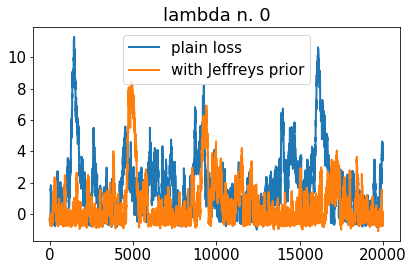

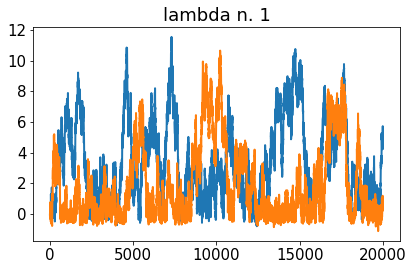

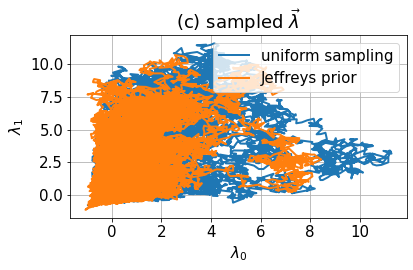

In [ ]:
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams.update({'figure.autolayout': True})

n_obs = sampling_noJ[0].shape[1]

for i in range(n_obs):
    plt.figure()
    plt.title('lambda n. %i' % i)
    plt.plot(sampling_noJ[0][:, i], label='plain loss')
    plt.plot(sampling_J[0][:, i], label='with Jeffreys prior')
    if i == 0 : plt.legend()

if (n_obs == 2):
    plt.figure(figsize=(6, 4))
    plt.plot(sampling_noJ[0][:, 0], sampling_noJ[0][:, 1], label='uniform sampling')
    plt.plot(sampling_J[0][:, 0], sampling_J[0][:, 1], label='Jeffreys prior')
    plt.xlabel('$\lambda_0$')
    plt.ylabel('$\lambda_1$')
    plt.legend()
    plt.grid()
    plt.title(r'(c) sampled $\vec\lambda$')
    # plt.savefig('Manuscript_images/ex2_sampling_lambdas_b.pdf', format='pdf', bbox_inches='tight')

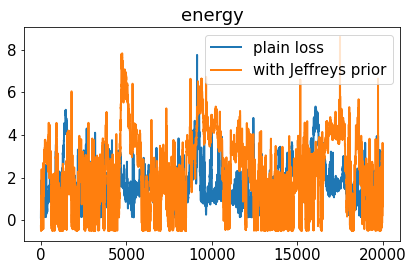

In [49]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams.update({'figure.autolayout': True})


plt.figure()
plt.title('energy')
plt.plot(sampling_noJ[1], label='plain loss')
plt.plot(sampling_J[1], label='with Jeffreys prior')
plt.legend()


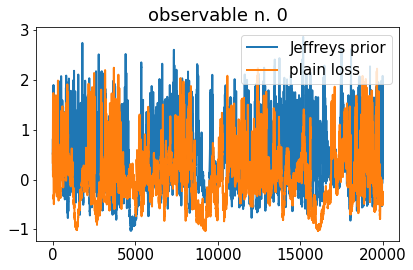

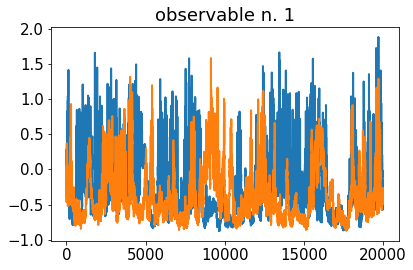

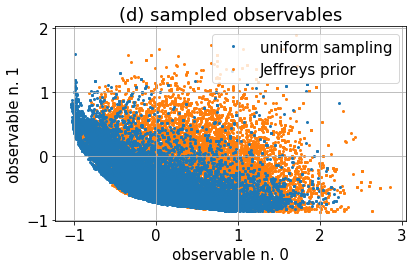

In [ ]:
for i in range(n_obs):
    plt.figure()
    plt.title('observable n. %i' % i)
    plt.plot(sampling_J[3][:, i], label='Jeffreys prior')
    plt.plot(sampling_noJ[3][:, i], label='plain loss')
    if i == 0 : plt.legend()

# plt.rcParams.update({'figure.autolayout': True})
plt.figure(figsize=(6, 4))
# plt.rcParams['lines.markeredgewidth'] = 0.5

plot_stride = 1
plt.plot(sampling_noJ[3][::plot_stride, 0], sampling_noJ[3][::plot_stride, 1], '.', label='uniform sampling', zorder=1, markersize=4, alpha=1)
plt.plot(sampling_J[3][::plot_stride, 0], sampling_J[3][::plot_stride, 1], '.', label='Jeffreys prior', zorder=0, markersize=4, alpha=1)

plt.xlabel('observable n. 0')
plt.ylabel('observable n. 1')
plt.legend()
plt.grid()
plt.title('(d) sampled observables')
# plt.savefig('Manuscript_images/ex2_sampling_obs_b.pdf', format='pdf', bbox_inches='tight')


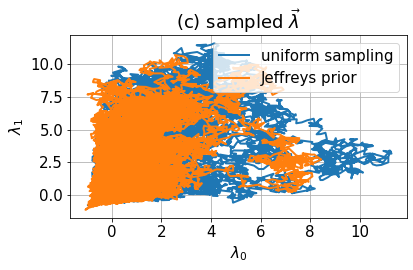

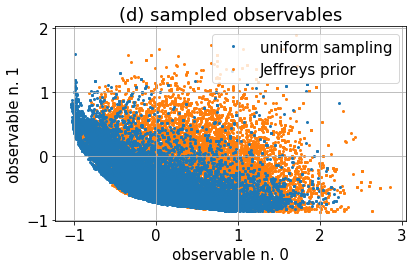

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(sampling_noJ[0][:, 0], sampling_noJ[0][:, 1], label='uniform sampling')
plt.plot(sampling_J[0][:, 0], sampling_J[0][:, 1], label='Jeffreys prior')
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.legend()
plt.grid()
plt.title(r'(c) sampled $\vec\lambda$')
# plt.savefig('Manuscript_images/ex2_sampling_lambdas_b.pdf', format='pdf', bbox_inches='tight')

plt.figure(figsize=(6, 4))
# plt.rcParams['lines.markeredgewidth'] = 0.5

plot_stride = 1
plt.plot(sampling_noJ[3][::plot_stride, 0], sampling_noJ[3][::plot_stride, 1], '.', label='uniform sampling', zorder=1, markersize=4, alpha=1)
plt.plot(sampling_J[3][::plot_stride, 0], sampling_J[3][::plot_stride, 1], '.', label='Jeffreys prior', zorder=0, markersize=4, alpha=1)

plt.xlabel('observable n. 0')
plt.ylabel('observable n. 1')
plt.legend()
plt.grid()
plt.title('(d) sampled observables')
# plt.savefig('Manuscript_images/ex2_sampling_obs_b.pdf', format='pdf', bbox_inches='tight')


### block analysis

In [22]:
from Functions.basic_functions_bayesian import block_analysis

In [25]:
bl_outs = {}

strides = [100, 50, 10, 5, 1]

for stride in strides:
    bl_outs[stride] = block_analysis(sampling_J[3][:, 1][::stride], None)

    print('stride: ', stride)
    print('average: ', bl_outs[stride][0])
    print('std: ', bl_outs[stride][1])
    print('optimal epsilon: ', bl_outs[stride][2])

stride:  100
average:  -0.4126835934460238
std:  0.033820086345461756
optimal epsilon:  0.14815239528785704
stride:  50
average:  -0.413402317826004
std:  0.024002168915546473
optimal epsilon:  0.1310623201243044
stride:  10
average:  -0.42990660793624536
std:  0.010084636876506266
optimal epsilon:  0.11531670227477397
stride:  5
average:  -0.43217692919607764
std:  0.007082417046033248
optimal epsilon:  0.07436083329176416
stride:  1
average:  -0.4312198503786818
std:  0.0031747731689780404
optimal epsilon:  0.056024379579048086


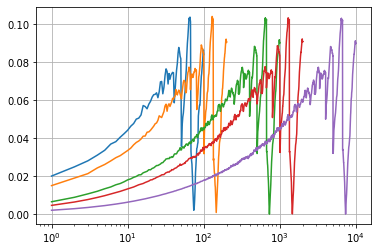

In [24]:
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i, stride in enumerate(strides):
    plt.plot(bl_outs[stride][6], bl_outs[stride][3], c=default_colors[i])
    # plt.plot(bl_outs[stride][6], bl_outs[stride][4], c=default_colors[i])
plt.xscale('log')
plt.grid()

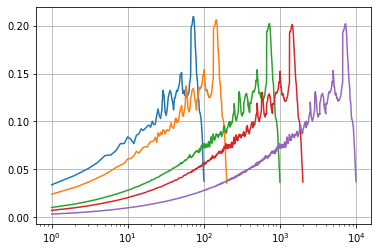

In [26]:
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i, stride in enumerate(strides):
    plt.plot(bl_outs[stride][6], bl_outs[stride][3], c=default_colors[i])
    # plt.plot(bl_outs[stride][6], bl_outs[stride][4], c=default_colors[i])
plt.xscale('log')
plt.grid()

## 2b. all the $^3 J$ couplings

### 5. analyse data from computations on cluster

#### reload data 
including both 'backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', since we will need to run `normalize_observables` in order to get `normg_mean` and `normg_std` 

#### read from remote folder
with `sshfs` (run the following cell just once)



- this slows down Numpy reads `np.load`

```
%timeit np.load('../Results_sampling_ER_old/Result_' + df_pars.index[1] + '/trajectory.npy')

6.49 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
```

```
%timeit np.load(path + 'Result_' + df_pars.index[1] + '/trajectory.npy')

4.2 s ± 176 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

- to solve this issue you can load `.npy` files as read-only (`mmap_mode='r'`), or alternatively you could tune `sshfs` options

`sshfs -o cache=yes -o cache_timeout=600 -o compression=yes user@host:/remote/path /local/mount`

`%timeit np.load(path + 'Result_' + df_pars.index[1] + '/trajectory.npy', mmap_mode='r')`

- if `dir` does not exist make it, if it is empty fill it with sshfs (otherwise it is already updated)


In [29]:
%%bash

dir='remote_data'

if [ ! -d "$dir" ]; then
    mkdir "$dir"
fi

if [ -z "$(ls -A "$dir")" ]; then
    sshfs igilardo@frontend2.hpc.sissa.it:/home/igilardo/5_Jeffreys/Results_sampling_ER "$dir"
fi

#### load and fix dataframe

In [30]:
path = 'remote_data/'  # '../Results_sampling_ER/'

file_list = list(np.sort(os.listdir(path)))
file_list.remove('normalized_values')

df_pars = []

for name in file_list[1:]:
    print(name)
    df_pars.append(pandas.read_csv(path + name + '/par_values', index_col=0))

df_pars = pandas.concat(df_pars, ignore_index=False).iloc[2:]

df_pars

Result_2025_05_15_17_44_10_845681
Result_2025_05_15_17_44_12_194451
Result_2025_05_15_17_52_31_914826
Result_2025_05_15_17_52_36_670959
Result_2025_05_15_18_40_13_500364
Result_2025_05_15_18_41_14_071270
Result_2025_05_15_18_43_28_270804
Result_2025_05_15_18_43_51_327121
Result_2025_05_15_18_56_54_397682
Result_2025_05_15_20_06_29_437759
Result_2025_05_16_19_41_26_084836
Result_2025_05_16_19_43_41_404477
Result_2025_05_16_20_10_53_613148
Result_2025_05_16_20_32_51_324995
Result_2025_05_16_22_56_57_222520
Result_2025_05_17_01_59_56_237682
Result_2025_05_28_17_49_28_796056
Result_2025_05_28_18_04_06_983061
Result_2025_05_28_18_55_50_399304
Result_2025_05_29_08_49_27_427206
Result_2025_05_29_08_52_20_959036
Result_2025_05_29_17_01_51_621759
Result_2025_05_29_17_04_36_623758
Result_2025_05_29_17_55_06_717604
Result_2025_05_29_18_00_35_501063
Result_2025_05_29_18_04_57_737569
Result_2025_05_29_18_53_31_174209
Result_2025_05_29_19_39_19_914627
Result_2025_05_29_19_56_47_436295
Result_2025_05

,stride,alpha ER,normalize?,reduce?,Jeffreys?,dlambda,n_steps,av. acceptance,jobid,alpha,if_normalize,if_reduce,if_onebyone,dx,if_Jeffreys,time,which_measure,seed
2025_05_15_17_52_31_914826,1000.0,0.5,1.0,0.0,0.0,0.2,1000.0,0.801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_05_15_17_52_36_670959,1000.0,0.5,1.0,0.0,1.0,0.2,1000.0,0.491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_05_15_18_40_13_500364,1000.0,0.5,1.0,0.0,1.0,0.2,100000.0,0.65162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_05_15_18_41_14_071270,100.0,0.5,1.0,0.0,0.0,0.2,100000.0,0.95413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025_05_15_18_43_28_270804,1000.0,0.5,1.0,0.0,0.0,0.2,100000.0,0.96391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025_07_01_11_52_53_333474,5000.0,NaN,NaN,NaN,NaN,NaN,100000.0,0.01386,16842810.0,10.0,1.0,0.0,0.0,0.2,NaN,37160.904573,3.0,4.0
2025_07_01_12_02_20_840936,5000.0,NaN,NaN,NaN,NaN,NaN,100000.0,0.03708,16842811.0,10.0,1.0,0.0,0.0,0.2,NaN,37411.501273,1.0,2.0
2025_07_01_12_04_13_525025,5000.0,NaN,NaN,NaN,NaN,NaN,100000.0,0.03589,16842812.0,10.0,1.0,0.0,0.0,0.2,NaN,37427.751096,1.0,4.0
2025_07_01_12_09_02_360673,5000.0,NaN,NaN,NaN,NaN,NaN,100000.0,0.01265,16842814.0,10.0,1.0,0.0,0.0,0.2,NaN,37588.997513,3.0,2.0


In [31]:
n_obs = []

for ind in df_pars.index:
    print(ind)
    n_obs.append(np.load(path + 'Result_' + ind + '/trajectory.npy', mmap_mode='r').shape[1])

df_pars['n_obs'] = n_obs

df_pars

2025_05_15_17_52_31_914826
2025_05_15_17_52_36_670959
2025_05_15_18_40_13_500364
2025_05_15_18_41_14_071270
2025_05_15_18_43_28_270804
2025_05_15_18_43_51_327121
2025_05_15_18_56_54_397682
2025_05_15_20_06_29_437759
2025_05_16_19_41_26_084836
2025_05_16_19_43_41_404477
2025_05_16_20_10_53_613148
2025_05_16_20_32_51_324995
2025_05_16_22_56_57_222520
2025_05_17_01_59_56_237682
2025_05_28_17_49_28_796056
2025_05_28_18_04_06_983061
2025_05_28_18_55_50_399304
2025_05_29_08_49_27_427206
2025_05_29_08_52_20_959036
2025_05_29_17_01_51_621759
2025_05_29_17_04_36_623758
2025_05_29_17_55_06_717604
2025_05_29_18_00_35_501063
2025_05_29_18_04_57_737569
2025_05_29_18_53_31_174209
2025_05_29_19_39_19_914627
2025_05_29_19_56_47_436295
2025_05_29_20_17_16_243363
2025_05_29_20_24_13_936256
2025_05_29_20_58_56_586573
2025_05_29_21_02_13_286943
2025_05_29_21_02_15_929011
2025_05_29_21_04_22_547431
2025_05_29_21_07_26_293204
2025_05_29_21_08_05_071910
2025_05_29_21_08_12_489403
2025_05_29_21_09_49_341230
2

,stride,alpha ER,normalize?,reduce?,Jeffreys?,dlambda,n_steps,av. acceptance,jobid,alpha,if_normalize,if_reduce,if_onebyone,dx,if_Jeffreys,time,which_measure,seed,n_obs
2025_05_15_17_52_31_914826,1000.0,0.5,1.0,0.0,0.0,0.2,1000.0,0.801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2025_05_15_17_52_36_670959,1000.0,0.5,1.0,0.0,1.0,0.2,1000.0,0.491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2025_05_15_18_40_13_500364,1000.0,0.5,1.0,0.0,1.0,0.2,100000.0,0.65162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2025_05_15_18_41_14_071270,100.0,0.5,1.0,0.0,0.0,0.2,100000.0,0.95413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
2025_05_15_18_43_28_270804,1000.0,0.5,1.0,0.0,0.0,0.2,100000.0,0.96391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025_07_01_11_52_53_333474,5000.0,NaN,NaN,NaN,NaN,NaN,100000.0,0.01386,16842810.0,10.0,1.0,0.0,0.0,0.2,NaN,37160.904573,3.0,4.0,28
2025_07_01_12_02_20_840936,5000.0,NaN,NaN,NaN,NaN,NaN,100000.0,0.03708,16842811.0,10.0,1.0,0.0,0.0,0.2,NaN,37411.501273,1.0,2.0,28
2025_07_01_12_04_13_525025,5000.0,NaN,NaN,NaN,NaN,NaN,100000.0,0.03589,16842812.0,10.0,1.0,0.0,0.0,0.2,NaN,37427.751096,1.0,4.0,28
2025_07_01_12_09_02_360673,5000.0,NaN,NaN,NaN,NaN,NaN,100000.0,0.01265,16842814.0,10.0,1.0,0.0,0.0,0.2,NaN,37588.997513,3.0,2.0,28


In [32]:
new_names = ['alpha', 'if_normalize', 'if_reduce', 'if_Jeffreys', 'dx']
old_names = ['alpha ER', 'normalize?', 'reduce?', 'Jeffreys?', 'dlambda']

for i in range(len(new_names)):
    df_pars[old_names[i]] = df_pars[old_names[i]].fillna(df_pars[new_names[i]])
    df_pars = df_pars.drop(columns=[new_names[i]])

new_names = ['Jeffreys?']
old_names = ['which_measure']

for i in range(len(new_names)):
    df_pars[old_names[i]] = df_pars[old_names[i]].fillna(df_pars[new_names[i]])
    df_pars = df_pars.drop(columns=[new_names[i]])

whole_df_pars = df_pars
del df_pars

# old if_onebyone Nan values correspond to 0 (False), since I implemented this later
whole_df_pars.loc[np.isnan(whole_df_pars['if_onebyone']), 'if_onebyone'] = 0

whole_df_pars

,stride,alpha ER,normalize?,reduce?,dlambda,n_steps,av. acceptance,jobid,if_onebyone,time,which_measure,seed,n_obs
2025_05_15_17_52_31_914826,1000.0,0.5,1.0,0.0,0.2,1000.0,0.801,NaN,0.0,NaN,0.0,NaN,8
2025_05_15_17_52_36_670959,1000.0,0.5,1.0,0.0,0.2,1000.0,0.491,NaN,0.0,NaN,1.0,NaN,8
2025_05_15_18_40_13_500364,1000.0,0.5,1.0,0.0,0.2,100000.0,0.65162,NaN,0.0,NaN,1.0,NaN,8
2025_05_15_18_41_14_071270,100.0,0.5,1.0,0.0,0.2,100000.0,0.95413,NaN,0.0,NaN,0.0,NaN,8
2025_05_15_18_43_28_270804,1000.0,0.5,1.0,0.0,0.2,100000.0,0.96391,NaN,0.0,NaN,0.0,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025_07_01_11_52_53_333474,5000.0,10.0,1.0,0.0,0.2,100000.0,0.01386,16842810.0,0.0,37160.904573,3.0,4.0,28
2025_07_01_12_02_20_840936,5000.0,10.0,1.0,0.0,0.2,100000.0,0.03708,16842811.0,0.0,37411.501273,1.0,2.0,28
2025_07_01_12_04_13_525025,5000.0,10.0,1.0,0.0,0.2,100000.0,0.03589,16842812.0,0.0,37427.751096,1.0,4.0,28
2025_07_01_12_09_02_360673,5000.0,10.0,1.0,0.0,0.2,100000.0,0.01265,16842814.0,0.0,37588.997513,3.0,2.0,28


#### compute normalized values `normg_mean` and `normg_std`

In [33]:
from MDRefine.MDRefine import normalize_observables

In [34]:
def save_dict_to_txt(my_dict, txt_path, sep : str=' '):
    """
    Save a dictionary as a txt file with column names given by indicization of dict keys.
    Each item value should be 0- or 1-dimensional (either int, float, np.ndarray or list),
    not 2-dimensional or more.
    """

    header = []
    values = []

    for key, arr in my_dict.items():
        if (type(arr) is int) or (type(arr) is float):
            header.append(key)
            values.append(arr)
        else:
            # assert ((type(arr) is np.ndarray) and (len(arr.shape) == 1)) or (type(arr) is list), 'error on element with key %s' % key
            # you could also have jax arrays, so manage as follows:

            try:
                l = len(arr.shape)
            except:
                l = 0
            assert (l == 1) or (type(arr) is list), 'error on element with key %s' % key
            
            # you should also check that each element in the list is 1-dimensional
            for i, val in enumerate(arr, 1):
                header.append(f"{key}_{i}")
                values.append(val)

    with open(txt_path, 'w') as f:
        f.write(sep.join(header) + '\n')
        f.write(sep.join(str(v) for v in values) + '\n')

    return

In [35]:
my_folder = "normalized_values"

if not os.path.exists(my_folder):
    os.mkdir(my_folder)

In [36]:
strides = np.sort(np.unique(np.int64(whole_df_pars['stride'])))

for stride in strides:
    print('stride: ', stride)

    data = load_data(infos, stride=stride)

    list_name_mol = list(data.mol.keys())

    for name_mol in list_name_mol:
        out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

        # data.mol[name_mol].g = out[0]
        # data.mol[name_mol].gexp = out[1]
        # data.mol[name_mol].normg_mean = out[2]
        # data.mol[name_mol].normg_std = out[3]
        
        normg_mean = out[2]
        normg_std = out[3]

        my_tuple = (my_folder, name_mol, stride)
        save_dict_to_txt(normg_mean, None)  # '%s/normg_mean_%s_%i' % my_tuple)
        save_dict_to_txt(normg_std, None)  # '%s/normg_std_%s_%i' % my_tuple)

stride:  5
loading data from directory...
loading  AAAA
done


TypeError: expected str, bytes or os.PathLike object, not NoneType

since it is difficult to get access to `normg_g_*.pickle`, we can read them from the folder `normalized_data` (`norm_g_mean` and `norm_g_std` are the same for each `stride` and `name_sys` since they are computed directly by `load_data`)

In [ ]:
!cp $my_folder remote_data/

mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_mean_AAAA_5': Permesso negato
mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_std_AAAA_5': Permesso negato
mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_mean_AAAA_10': Permesso negato
mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_std_AAAA_10': Permesso negato
mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_mean_AAAA_15': Permesso negato
mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_std_AAAA_15': Permesso negato
mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_mean_AAAA_20': Permesso negato
mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_std_AAAA_20': Permesso negato
mv: impossibile preservare il proprietario di 'remote_data/normalized_values/normg_mean_AAAA_3

#### select subset of the dataframe and load corresponding values

In [ ]:
# df_pars = df_pars[(df_pars['alpha ER'] == 10.) & (df_pars['reduce?'] == 0.) & (df_pars['n_obs'] == 28) & (df_pars['n_steps'] == int(1e5))]
df_pars = whole_df_pars.query(f'`alpha ER` == 10 and `reduce?` == 0 and n_obs == 28 and n_steps == {int(1e5)}' \
    'and if_onebyone == 0.')

df_pars = df_pars.sort_values(by='stride')

my_types = ['plain', 'J', 'Dir']

inds = {}
strides = {}

for i, s in enumerate(my_types):
    inds[s] = df_pars[df_pars['which_measure'] == float(i)].index
    strides[s] = df_pars[df_pars['which_measure'] == float(i)]['stride']

for s in strides.keys(): strides[s] = strides[s].astype(np.int64)

df_pars

,stride,alpha ER,normalize?,reduce?,dlambda,n_steps,av. acceptance,jobid,if_onebyone,time,which_measure,seed,n_obs
2025_06_30_20_11_47_143618,5.0,10.0,1.0,0.0,0.2,100000.0,0.13197,16842600.0,0.0,14208.828379,0.0,3.0,28
2025_06_30_18_06_38_029634,5.0,10.0,1.0,0.0,0.2,100000.0,0.12487,16842575.0,0.0,7521.439580,0.0,1.0,28
2025_06_30_19_49_44_680873,5.0,10.0,1.0,0.0,0.2,100000.0,0.13115,16842601.0,0.0,12872.294210,0.0,4.0,28
2025_06_23_17_03_56_048526,5.0,10.0,1.0,0.0,0.2,100000.0,0.12963,16763020.0,0.0,8295.005488,0.0,NaN,28
2025_06_30_18_54_05_569794,5.0,10.0,1.0,0.0,0.2,100000.0,0.13144,16842599.0,0.0,9533.173697,0.0,2.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025_06_28_09_39_32_861817,5000.0,10.0,1.0,0.0,0.2,100000.0,0.01378,16831451.0,0.0,42277.278928,3.0,NaN,28
2025_06_28_09_53_40_619227,5000.0,10.0,1.0,0.0,0.2,100000.0,0.02151,16831453.0,0.0,43063.385726,2.0,NaN,28
2025_06_30_16_36_52_133052,5000.0,10.0,1.0,0.0,0.2,100000.0,0.15159,16842592.0,0.0,2097.415498,0.0,1.0,28
2025_07_01_11_20_03_341347,5000.0,10.0,1.0,0.0,0.2,100000.0,0.01374,16842807.0,0.0,36078.990763,3.0,3.0,28


In [59]:
path = 'remote_data/'  # '../Results_sampling_ER/'

qs = {}
mus = {}
stds = {}

for s in my_types:

    qs[s] = []
    mus[s] = []
    stds[s] = []

    for ind in inds[s]:
        qs[s].append(np.load(path + 'Result_' + ind + '/quantities.npy', mmap_mode='r'))
        mus[s].append(np.mean(qs[s][-1], axis=0))
        stds[s].append(np.std(qs[s][-1], axis=0))

    mus[s] = np.array(mus[s])
    stds[s] = np.array(stds[s])


In [34]:
if 'if_one_by_one' in df_pars.keys():  # df_pars['if_one_by_one'].iloc[0]:
    mus_onebyone = mus
    stds_onebyone = stds
    strides_onebyone = strides

denormalize and plot also experimental and average values

In [60]:
path = 'remote_data/normalized_values/normg_%s_AAAA_'

normg_mean = {}
normg_std = {}

for stride in strides['plain']:
    normg_mean[stride] = np.array(pandas.read_csv((path % 'mean') + str(stride), sep=' '))[0]
    normg_std[stride] = np.array(pandas.read_csv((path % 'std') + str(stride), sep=' '))[0]

In [61]:
def denormalize(values, normg_mean, normg_std, if_mean: bool=True):
    """
    denormalize mean (if if_mean) or standard deviation (if not if_mean)
    """
    if normg_mean is not None:
        denormalized_values = values*normg_std + normg_mean
    else:
        denormalized_values = values*normg_std
    return np.array(denormalized_values)

In [62]:
for s in mus.keys():
    for i in range(len(mus[s])):
        # up to -1, since the last is the relative entropy
        stride = strides[s].iloc[i]
        mus[s][i][:-1] = denormalize(mus[s][i][:-1], normg_mean[stride], normg_std[stride])
        stds[s][i][:-1] = denormalize(stds[s][i][:-1], None, normg_std[stride])


In [75]:
my_gexp = data.mol['AAAA'].gexp

g_exps = np.concatenate([my_gexp[s][:, 0] for s in my_gexp.keys()])
err_exps = np.concatenate([my_gexp[s][:, 1] for s in my_gexp.keys()])

In [50]:
strides[s]

2025_06_30_20_11_47_143618       5
2025_06_30_18_06_38_029634       5
2025_06_30_19_49_44_680873       5
2025_06_23_17_03_56_048526       5
2025_06_30_18_54_05_569794       5
                              ... 
2025_07_01_11_18_29_239449    5000
2025_07_01_11_00_51_665616    5000
2025_06_23_15_36_35_560040    5000
2025_06_28_09_31_37_843597    5000
2025_06_30_16_36_52_133052    5000
Name: stride, Length: 104, dtype: int64

IndexError: index 8 is out of bounds for axis 0 with size 8

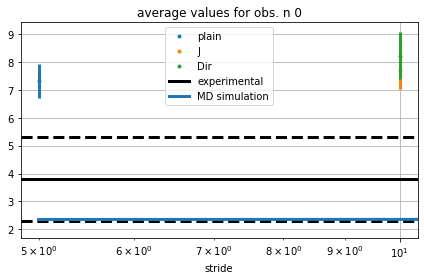

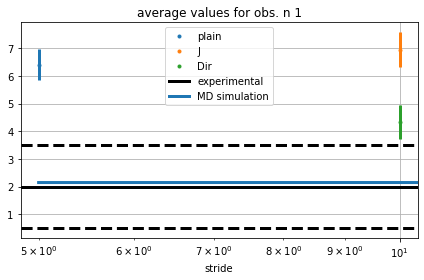

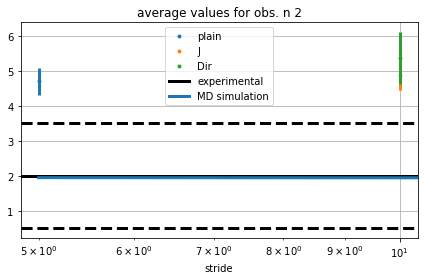

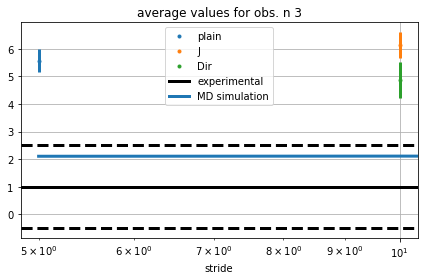

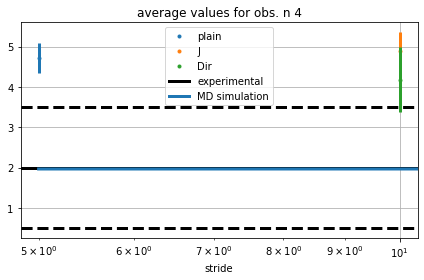

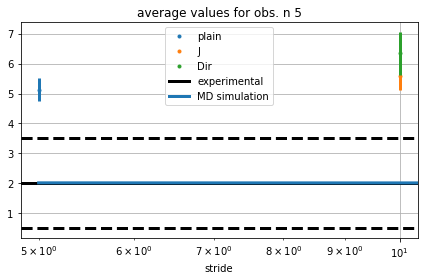

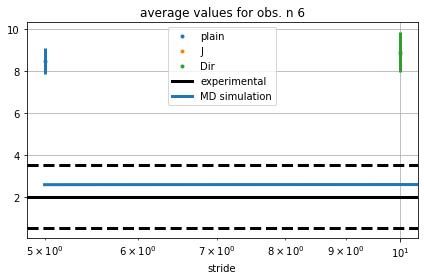

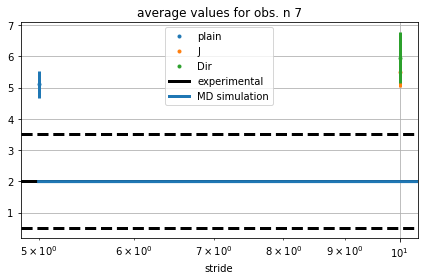

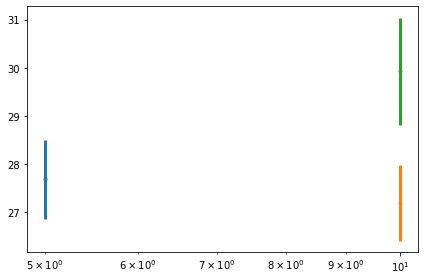

In [51]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

# my_types = ['plain', 'J']

for n_obs in range(20):

    plt.figure()

    # focus on observable n. 8 !!
    j = 0

    for i, s in enumerate(my_types):
        plt.plot(strides[s][j], mus[s][j, n_obs], '.', label=s, c=colors[i])
        plt.errorbar(strides[s][j], mus[s][j, n_obs], yerr=stds[s][j, n_obs], c=colors[i])

    plt.xscale('log')
    xlim = plt.xlim()

    plt.plot(xlim, g_exps[n_obs]*np.ones(2), '-k', label='experimental')
    plt.plot(xlim, (g_exps[n_obs] + err_exps[n_obs])*np.ones(2), '--k')
    plt.plot(xlim, (g_exps[n_obs] - err_exps[n_obs])*np.ones(2), '--k')

    avgs = np.array([(stride, normg_mean[stride][n_obs]) for stride in np.unique(strides['plain'])])
    plt.plot(avgs[:, 0], avgs[:, 1], label='MD simulation')

    plt.xlim(xlim)
    plt.grid()
    plt.title('average values for obs. n %i' % n_obs)
    plt.xlabel('stride')
    plt.legend()

In [66]:
g_exps

array([3.8, 2. , 2. , 1. , 2. , 2. , 2. , 2. ])

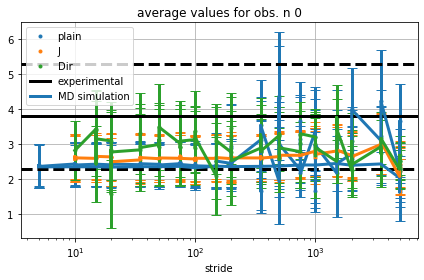

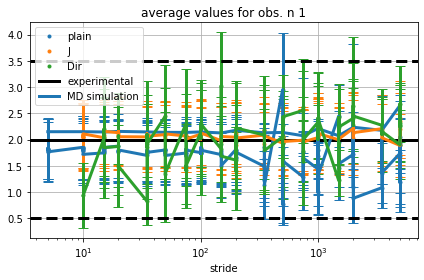

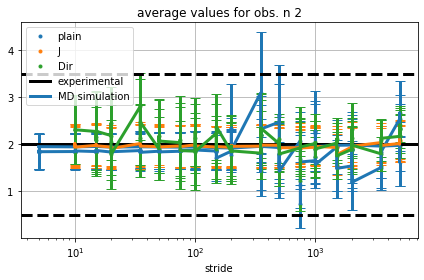

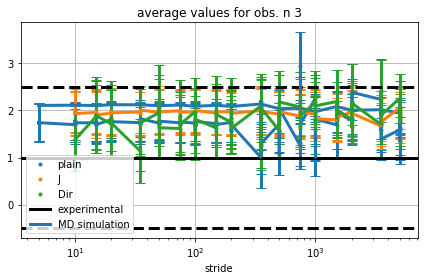

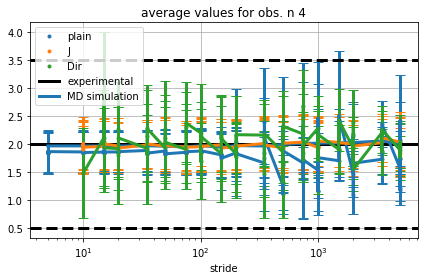

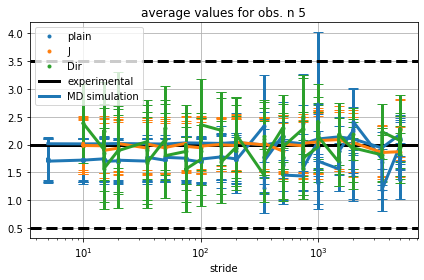

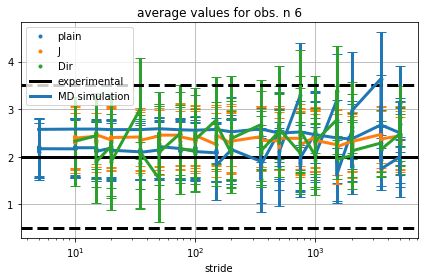

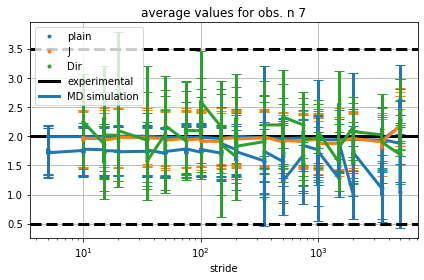

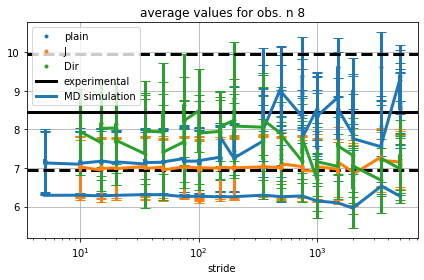

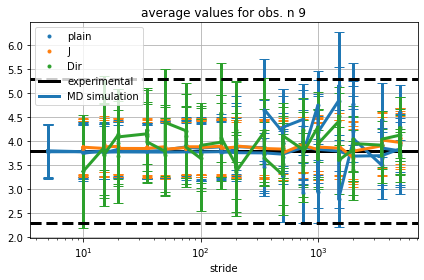

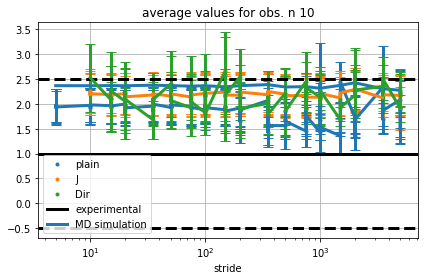

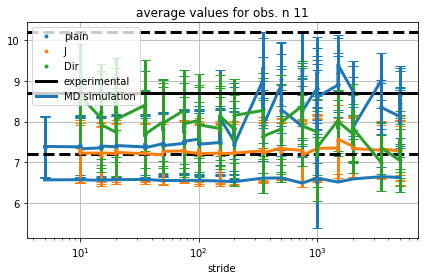

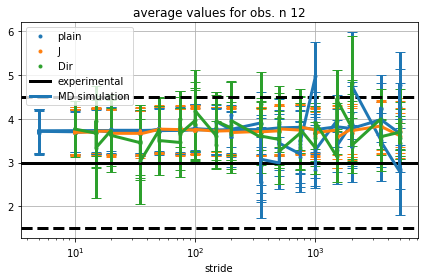

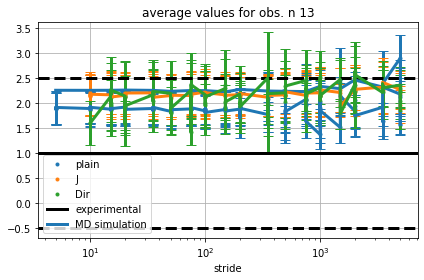

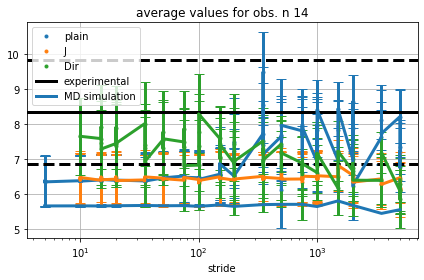

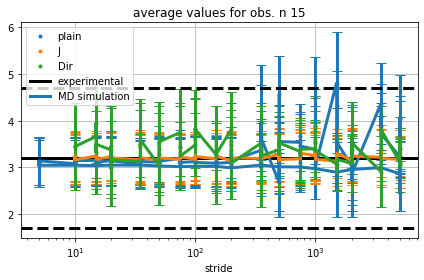

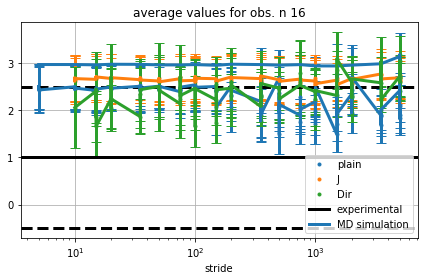

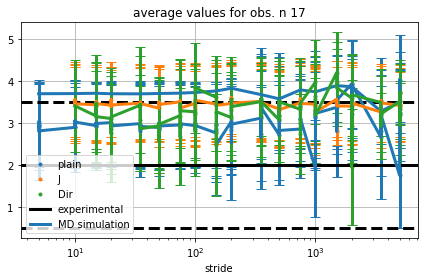

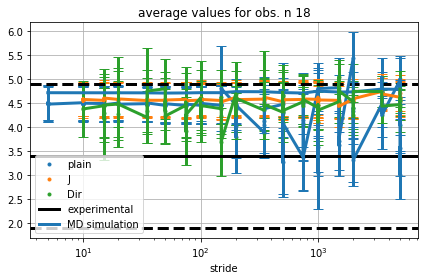

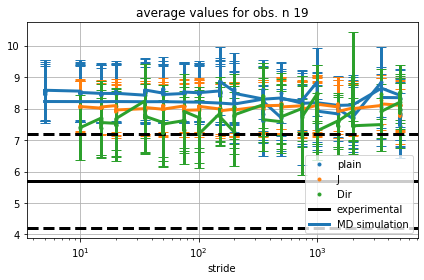

In [76]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

# my_types = ['plain', 'J']

for n_obs in range(20):

    plt.figure()

    # focus on observable n. 8 !!
    for i, s in enumerate(my_types):
        plt.plot(strides[s], mus[s][:, n_obs], '.', label=s, c=colors[i])
        plt.errorbar(strides[s], mus[s][:, n_obs], yerr=stds[s][:, n_obs], c=colors[i], capsize=5)

    plt.xscale('log')
    xlim = plt.xlim()

    plt.plot(xlim, g_exps[n_obs]*np.ones(2), '-k', label='experimental')
    plt.plot(xlim, (g_exps[n_obs] + err_exps[n_obs])*np.ones(2), '--k')
    plt.plot(xlim, (g_exps[n_obs] - err_exps[n_obs])*np.ones(2), '--k')

    avgs = np.array([(stride, normg_mean[stride][n_obs]) for stride in np.unique(strides['plain'])])
    plt.plot(avgs[:, 0], avgs[:, 1], label='MD simulation')

    plt.xlim(xlim)
    plt.grid()
    plt.title('average values for obs. n %i' % n_obs)
    plt.xlabel('stride')
    plt.legend()

#### ... old

- denormalize

In [ ]:
strides['plain']

# mus['plain']

mus['plain'].shape

for i in range(len(mus['plain'])):
    mus['plain'][i] = denormalize(mus['plain'][i], )

(104, 29)

In [ ]:
i_noJ = [1, 0, 4]  # 0, 2, 4]
iJ = [2, 3, 5]  # 1, 3, 5]

enes_noJ = []
enes_J = []
qs_noJ = []
qs_J = []
trajs_noJ = []
trajs_J = []

for i in i_noJ:
    enes_noJ.append(np.load(path + 'Result_' + inds[i] + '/energy.npy'))
    qs_noJ.append(np.load(path + 'Result_' + inds[i] + '/quantities.npy'))
    trajs_noJ.append(np.load(path + 'Result_' + inds[i] + '/trajectory.npy'))

for i in iJ:
    enes_J.append(np.load(path + 'Result_' + inds[i] + '/energy.npy'))
    qs_J.append(np.load(path + 'Result_' + inds[i] + '/quantities.npy'))
    trajs_J.append(np.load(path + 'Result_' + inds[i] + '/trajectory.npy'))


In [ ]:
for i in range(len(qs_J)):
    print(np.mean(qs_J[i][:, 1]))

for i in range(len(qs_J)):
    print(np.mean(qs_noJ[i][:, 1]))

0.0002772580123915908
-0.007784866746370384
0.12751803885747065
-0.3784372764083646
-0.14460544594257552
-0.1847132538595441


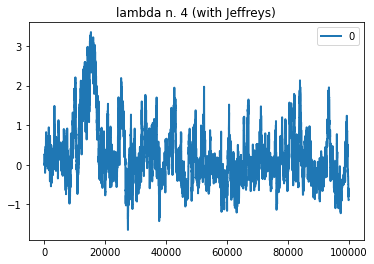

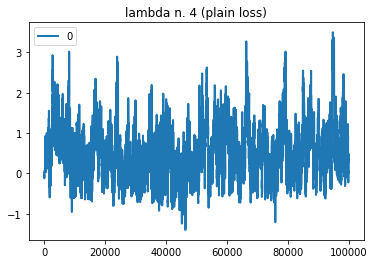

In [ ]:
i_obs = 4

plt.title('lambda n. %i (with Jeffreys)' % i_obs)
for i in range(len(trajs_J)):
    plt.plot(trajs_J[i][:, i_obs], label=i)
plt.legend()

plt.figure()
plt.title('lambda n. %i (plain loss)' % i_obs)
for i in range(len(trajs_J)):
    plt.plot(trajs_noJ[i][:, i_obs], label=i)
plt.legend()

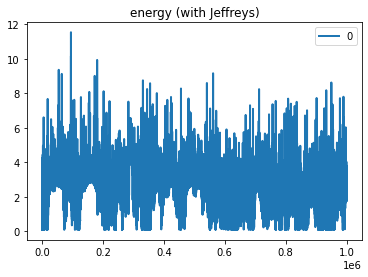

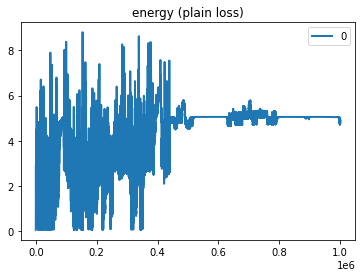

In [ ]:
plt.title('energy (with Jeffreys)')
for i in range(len(trajs_J)):
    plt.plot(enes_J[i], label=i)
plt.legend()

plt.figure()
plt.title('energy (plain loss)')
for i in range(len(trajs_J)):
    plt.plot(enes_noJ[i], label=i)
plt.legend()

In [37]:
i = 0

plt.plot(trajs_J[i][:, 0], label='with Jeffreys')
plt.plot(trajs_noJ[i][:, 0], label='plain loss')
plt.legend()

plt.figure()
plt.plot(trajs_J[i][:, 1], label='with Jeffreys')
plt.plot(trajs_noJ[i][:, 1], label='plain loss')
plt.legend()

plt.figure()
plt.plot(trajs_J[i][:, 0], trajs_J[i][:, 1], label='with Jeffreys')
plt.plot(trajs_noJ[i][:, 0], trajs_noJ[i][:, 1], label='plain loss')
plt.legend()

NameError: name 'trajs_J' is not defined

/home/ivang/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


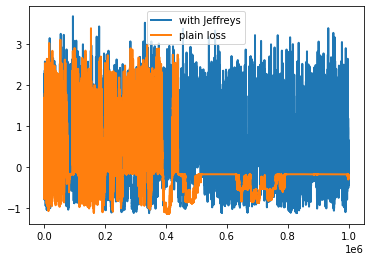

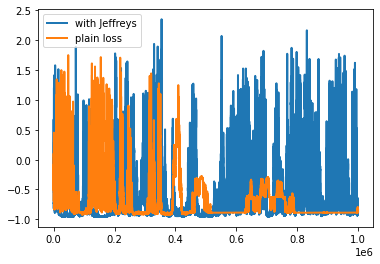

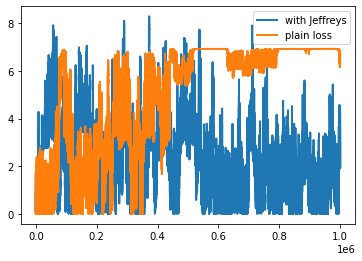

In [ ]:
plt.rcParams['lines.linewidth'] = 2

i = 0

for i_obs in range(qs_J[i].shape[1]):
    plt.figure()
    plt.plot(qs_J[i][:, i_obs], label='with Jeffreys')
    plt.plot(qs_noJ[i][:, i_obs], label='plain loss')
    plt.legend()


[-0.10129822 -0.71448011  4.95985835] [0.53385763 0.28085569 2.29808909]
[ 0.26762545 -0.65422426  2.10809968] [0.62780647 0.3422431  1.43327363]


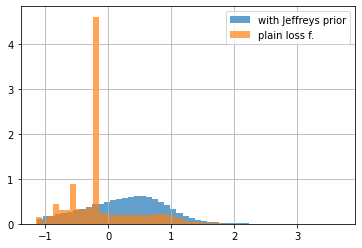

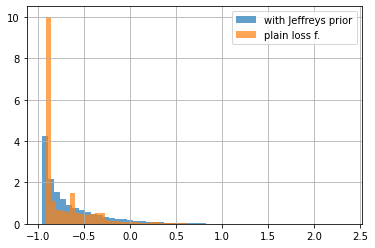

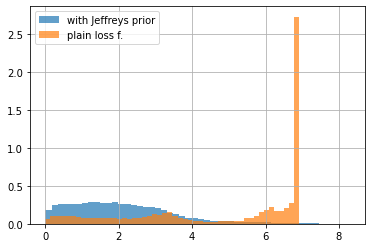

In [ ]:
for i_obs in range(qs_J[i].shape[1]):
    plt.figure()
    plt.hist(qs_J[i][:, i_obs], bins=50, label='with Jeffreys prior', alpha=0.7, density=True)
    plt.hist(qs_noJ[i][:, i_obs], bins=50, label='plain loss f.', alpha=0.7, density=True)

    plt.legend()
    plt.grid()

print(np.mean(qs_noJ[i], axis=0), np.std(qs_noJ[i], axis=0))
print(np.mean(qs_J[i], axis=0), np.std(qs_J[i], axis=0))

In [ ]:
mus_noJ = []
stds_noJ = []

for j in range(3):
    mus_noJ.append(np.mean(qs_noJ[j], axis=0))
    stds_noJ.append(np.std(qs_noJ[j], axis=0))

mus_J = []
stds_J = []

for j in range(3):
    mus_J.append(np.mean(qs_J[j], axis=0))
    stds_J.append(np.std(qs_J[j], axis=0))

mus_noJ = np.array(mus_noJ)
stds_noJ = np.array(stds_noJ)
mus_J = np.array(mus_J)
stds_J = np.array(stds_J)



In [ ]:
mus_J.shape

(3, 29)

/tmp/ipykernel_27804/1018691780.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


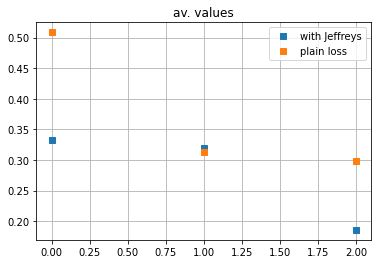

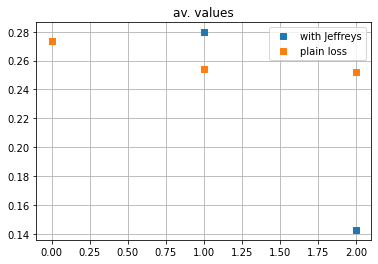

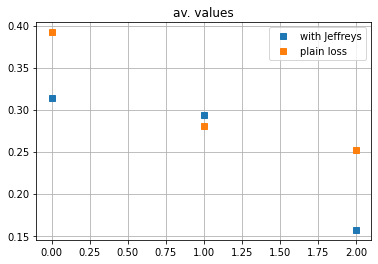

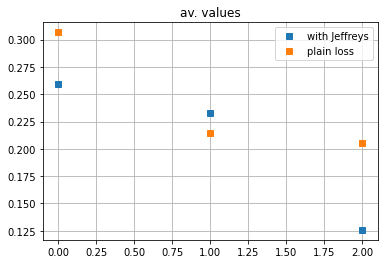

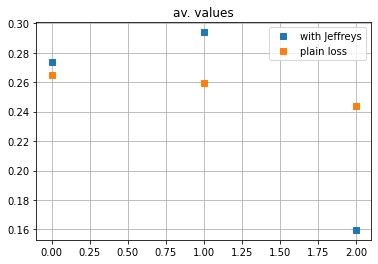

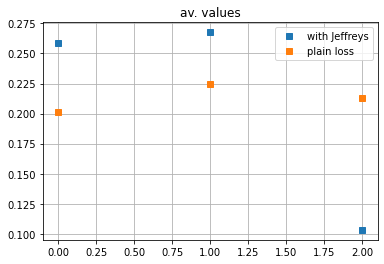

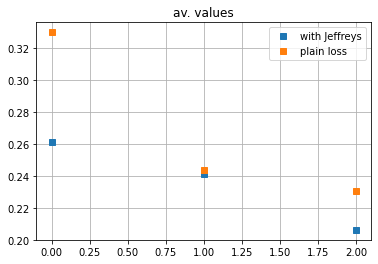

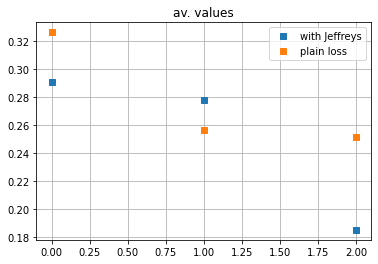

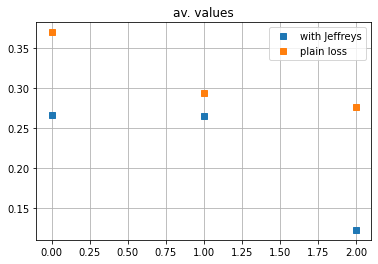

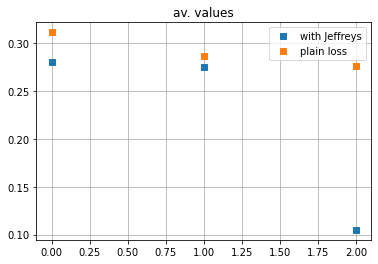

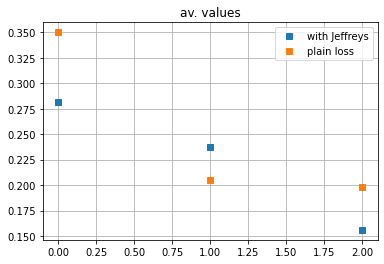

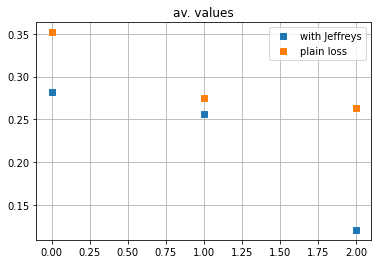

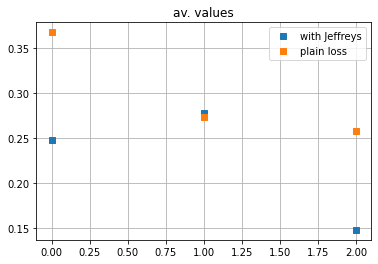

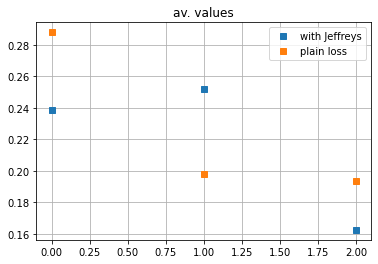

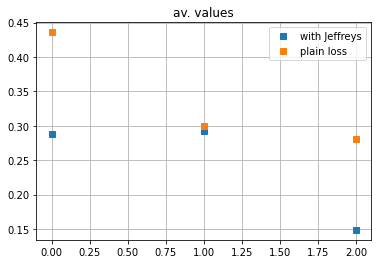

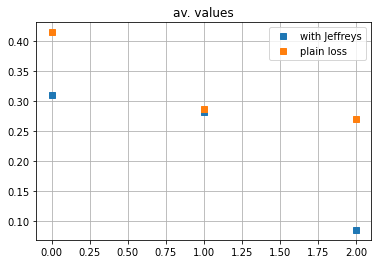

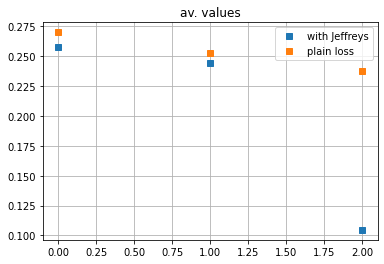

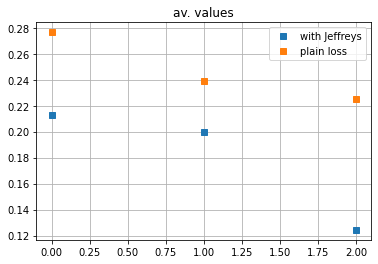

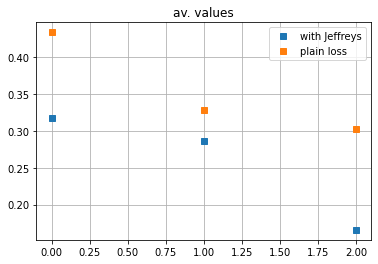

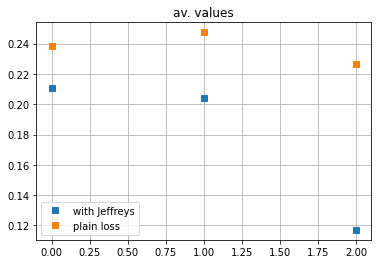

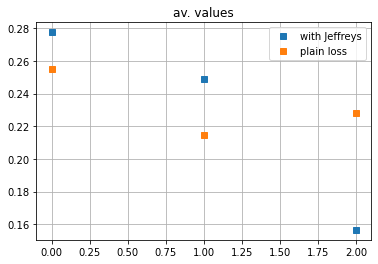

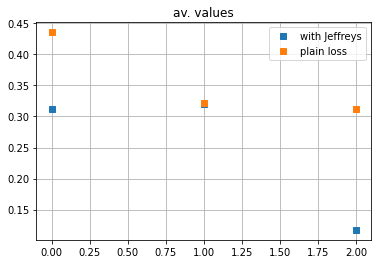

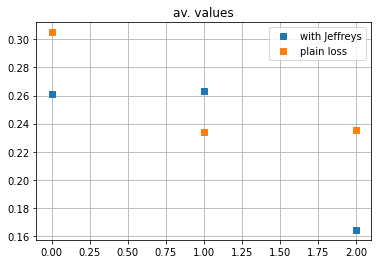

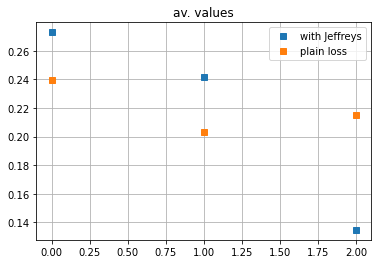

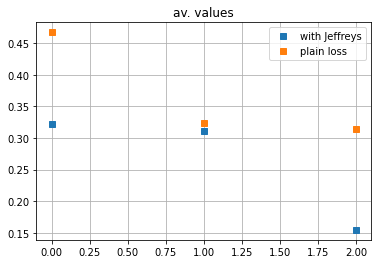

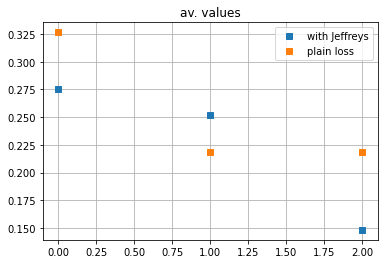

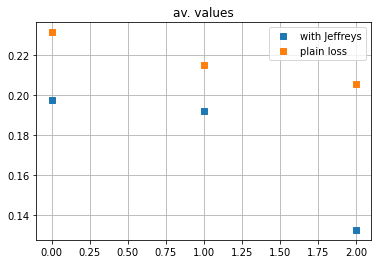

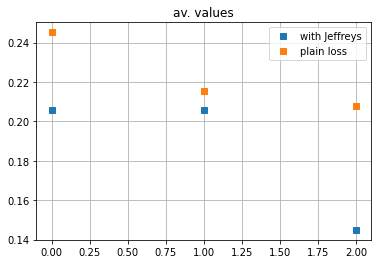

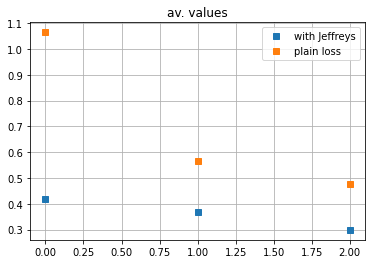

In [ ]:
for i in range(mus_J.shape[1]):
    plt.figure()
    plt.plot(stds_J[:, i], 's', label='with Jeffreys')
    plt.plot(stds_noJ[:, i], 's', label='plain loss')
    plt.title('av. values')
    plt.grid()
    plt.legend()


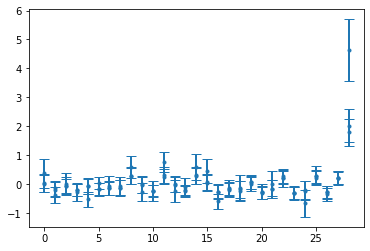

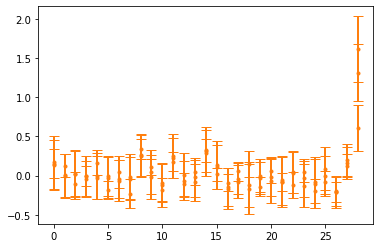

In [ ]:


    plt.plot(mu_noJ, '.', label='plain loss', c='tab:blue')
    plt.errorbar(np.arange(n_obs), mu_noJ, yerr=std_noJ, c='tab:blue', linestyle='', capsize=5)

    # plt.ylim([-0.6, 2.7])

plt.figure()

for j in range(3):
    mu_J = np.mean(qs_J[j], axis=0)
    std_J = np.std(qs_J[j], axis=0)
    n_obs = len(mu_noJ)

    plt.plot(mu_J, '.', label='with Jeffreys', c='tab:orange')
    plt.errorbar(np.arange(n_obs), mu_J, yerr=std_J, c='tab:orange', linestyle='', capsize=5)




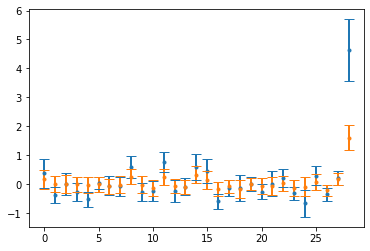

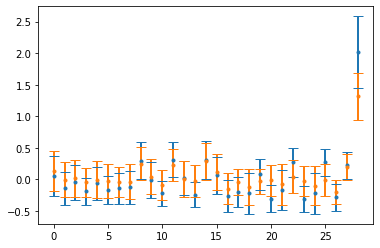

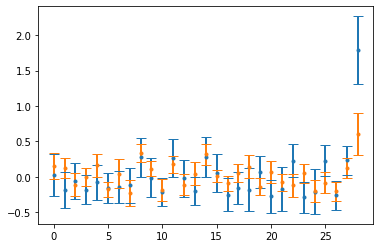

In [ ]:
for j in range(3):

    mu_noJ = np.mean(qs_noJ[j], axis=0)
    std_noJ = np.std(qs_noJ[j], axis=0)
    mu_J = np.mean(qs_J[j], axis=0)
    std_J = np.std(qs_J[j], axis=0)
    n_obs = len(mu_noJ)

    plt.figure()
    plt.plot(mu_noJ, '.', label='plain loss', c='tab:blue')
    plt.errorbar(np.arange(n_obs), mu_noJ, yerr=std_noJ, c='tab:blue', linestyle='', capsize=5)

    plt.plot(mu_J, '.', label='with Jeffreys', c='tab:orange')
    plt.errorbar(np.arange(n_obs), mu_J, yerr=std_J, c='tab:orange', linestyle='', capsize=5)

    # plt.ylim([-0.6, 2.7])

In [ ]:
mu_noJ

array([ 0.02378554, -0.18471325, -0.05772193, -0.18788781, -0.07897807,
       -0.16111943, -0.14427198, -0.12207683,  0.27761279, -0.01532106,
       -0.22249137,  0.26247316, -0.02297508, -0.20453708,  0.2731835 ,
        0.05390234, -0.25251629, -0.1565103 , -0.18147154,  0.07243162,
       -0.27857229, -0.16991915,  0.2258048 , -0.29158194, -0.21195695,
        0.22776698, -0.25911685,  0.22958892,  1.79087274])

<ErrorbarContainer object of 3 artists>

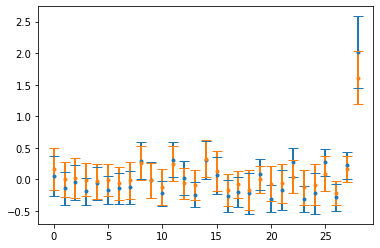

In [ ]:
mu_noJ = np.mean(qs_noJ[0], axis=0)
std_noJ = np.std(qs_noJ[0], axis=0)
mu_J = np.mean(qs_J[0], axis=0)
std_J = np.std(qs_J[0], axis=0)
n_obs = len(mu_noJ)

plt.plot(mu_noJ, '.', label='plain loss', c='tab:blue')
plt.errorbar(np.arange(n_obs), mu_noJ, yerr=std_noJ, c='tab:blue', linestyle='', capsize=5)

plt.plot(mu_J, '.', label='with Jeffreys', c='tab:orange')
plt.errorbar(np.arange(n_obs), mu_J, yerr=std_J, c='tab:orange', linestyle='', capsize=5)

In [ ]:
from MDRefine.MDRefine import normalize_observables

name_mol = 'AAAA'
out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

if trajs_J[0].shape[1] == 8: obs_name = 'backbone1_gamma_3J'
elif trajs_J[0].shape[1] == 9: obs_name = 'backbone2_beta_epsilon_3J'

normg_mean = out[2][obs_name]
normg_std = out[3][obs_name]

In [ ]:
def denormalize(values, normg_mean, normg_std):
    denormalized_values = values*normg_std + normg_mean
    return np.array(denormalized_values)

[ 0.25871592 -0.01489745 -0.20838638  0.23037743 -0.02353989 -0.19353456
  0.25859886  0.04676909 -0.24165572  0.6097944 ] [0.27272447 0.26938759 0.21165208 0.26512747 0.26286247 0.21370088
 0.28443645 0.27577239 0.24256395 0.25006636]
[ 0.23804009  0.03497916 -0.10502767  0.20857605 -0.00357601 -0.07741136
  0.27020491  0.11123554 -0.17207738  0.48573619] [0.26368383 0.2800998  0.25131709 0.26653159 0.27721319 0.25580637
 0.28659931 0.29349735 0.2535687  0.22073641]


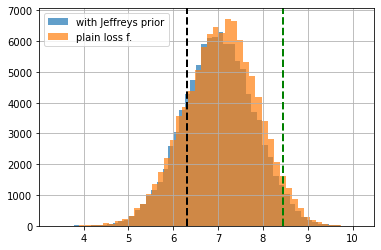

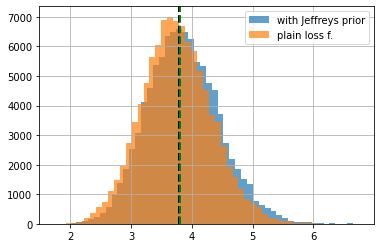

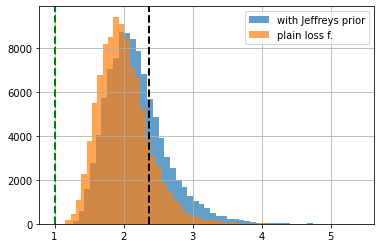

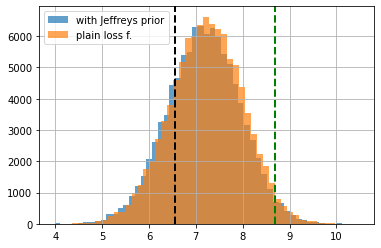

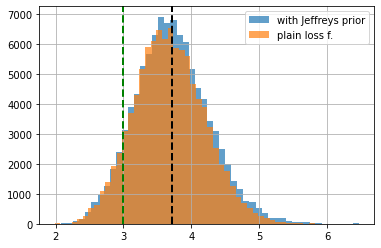

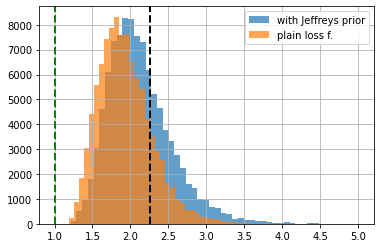

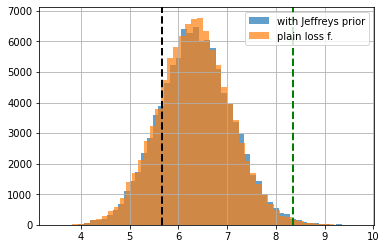

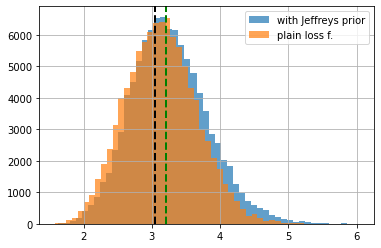

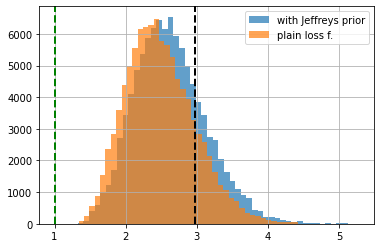

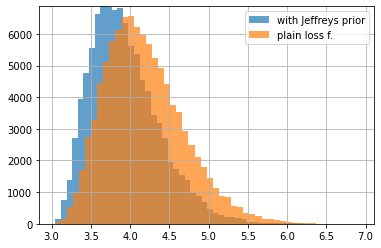

In [ ]:
i = 0

for i_obs in range(qs_J[i].shape[1]):
    plt.figure()

    den_qs_J = denormalize(qs_J[i][:, i_obs], normg_mean[i_obs], normg_std[i_obs])
    den_qs_noJ = denormalize(qs_noJ[i][:, i_obs], normg_mean[i_obs], normg_std[i_obs])

    plt.hist(den_qs_J, bins=50, label='with Jeffreys prior', alpha=0.7)
    plt.hist(den_qs_noJ, bins=50, label='plain loss f.', alpha=0.7)

    if i_obs < data.mol[name_mol].gexp[obs_name].shape[0]:
        ylim = plt.ylim()
        plt.plot(normg_mean[i_obs]*np.ones(2), ylim, '--k')
        plt.plot(data.mol[name_mol].gexp[obs_name][i_obs, 0]*np.ones(2), ylim, '--g')

    plt.ylim(ylim)
    plt.legend()
    plt.grid()

print(np.mean(qs_noJ[i], axis=0), np.std(qs_noJ[i], axis=0))
print(np.mean(qs_J[i], axis=0), np.std(qs_J[i], axis=0))

In [ ]:
normg_mean

Array([6.29820565, 3.78697469, 2.36639065, 6.56558296, 3.72321658,
       2.25371876, 5.65774102, 3.0512685 , 2.96928404], dtype=float64)

In [ ]:
avs_noJ = np.mean(qs_noJ[i][:-1], axis=0)
stds_noJ = np.std(qs_noJ[i][:-1], axis=0)
avs_J = np.mean(qs_J[i], axis=0)
stds_J = np.std(qs_J[i], axis=0)

# denormalize observables
avs_noJ[:-1] = avs_noJ[:-1]*normg_std + normg_mean
stds_noJ[:-1] = stds_noJ[:-1]*normg_std
avs_J[:-1] = avs_J[:-1]*normg_std + normg_mean
stds_J[:-1] = stds_J[:-1]*normg_std

plt.plot(avs_noJ, 's', c='tab:blue')
plt.errorbar(np.arange(len(avs_noJ)), avs_noJ, yerr=stds_noJ, linestyle='', capsize=10, c='tab:blue')

plt.plot(avs_J, 's', c='tab:orange')
plt.errorbar(np.arange(len(avs_J)), avs_J, yerr=stds_J, linestyle='', capsize=10., c='tab:orange')

g_exp = data.mol['AAAA'].gexp[obs_name]
std_exp = g_exp[:, 1]
g_exp = g_exp[:, 0]
plt.plot(g_exp, 's', c='tab:green')
plt.errorbar(np.arange(len(g_exp)), g_exp, yerr=std_exp, linestyle='', capsize=10., c='tab:green')

plt.plot(normg_mean, 'd', c='tab:red')

plt.grid()

TypeError: mul got incompatible shapes for broadcasting: (9,), (8,).

In [ ]:
i = 2

plt.plot(enes_J[i], label='with Jeffreys')
plt.plot(enes_noJ[i], label='plain loss')
plt.legend()

IndexError: list index out of range

##### block analysis

In [ ]:
from Functions.basic_functions_bayesian import block_analysis

In [ ]:
bl_outs = {}

strides = [1000, 100, 10]

for stride in strides:
    bl_outs[stride] = block_analysis(qs_J[:, 1][::stride], None)

    print('stride: ', stride)
    print('average: ', bl_outs[stride].mean)
    print('std: ', bl_outs[stride].std)
    print('optimal epsilon: ', bl_outs[stride].opt_epsilon, '\n')


stride:  1000
average:  -0.387293620247926
std:  0.013346974605666913
optimal epsilon:  0.023957996517052688 

stride:  100
average:  -0.39257076562575294
std:  0.004189330977435966
optimal epsilon:  0.01836494227217556 



KeyboardInterrupt: 

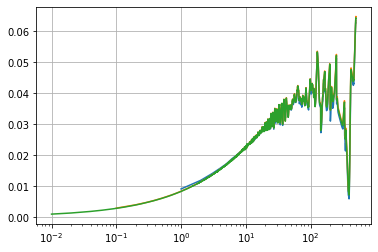

In [ ]:
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

ratios = [strides[0]/strides[i] for i in range(len(strides))]

for i, stride in enumerate(strides):
    plt.plot(bl_outs[stride].size_blocks/ratios[i], bl_outs[stride].epsilons, c=default_colors[i])
    # plt.plot(bl_outs[stride].size_blocks, bl_outs[stride].smooth, c=default_colors[i])
plt.xscale('log')
plt.grid()

In [ ]:
mu_J = np.mean(qs_J[:, 0])
mu_noJ = np.mean(qs_noJ[:, 0])

print(mu_J, mu_noJ)

0.25578586088983724 -0.10129821580399317


In [ ]:
i = 2

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(qs_noJ[:, i], label='plain loss')
plt.plot(qs_J[:, i], label='with Jeffreys')
plt.legend()
plt.title('av. value obs. n. %i' % i)

plt.subplot(1, 2, 2)
plt.hist(qs_noJ[:, i], bins=100, density=True, alpha=0.7, label='plain loss')
plt.hist(qs_J[:, i], bins=100, density=True, alpha=0.7, label='with Jeffreys')
plt.legend()
plt.title('av. value obs. n. %i - histogram' % i)

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(traj_noJ[:, i], label='plain loss')
plt.plot(traj_J[:, i], label='with Jeffreys')
plt.legend()
plt.title('lambda n. %i' % i)

plt.subplot(1, 2, 2)
plt.hist(traj_noJ[:, i], bins=100, density=True, alpha=0.7, label='plain loss')
plt.hist(traj_J[:, i], bins=100, density=True, alpha=0.7, label='with Jeffreys')
plt.legend()
plt.title('lambda n. %i - histogram' % i)

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('relative entropy')
plt.plot(qs_noJ[:, -1], label='plain loss')
plt.plot(qs_J[:, -1], label='with Jeffreys')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('energy')
plt.plot(ene_noJ, label='plain loss')
plt.plot(ene_J, label='with Jeffreys')


IndexError: index 2 is out of bounds for axis 1 with size 2

/home/ivang/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7fae9e24e040> (for post_execute):


KeyboardInterrupt: 

In [ ]:
from Functions.basic_functions_bayesian import block_analysis

In [ ]:
bl_out = block_analysis(qs_J[:, -1], n_conv=1000)

In [ ]:
bl_out.keys()

dict_keys(['mean', 'std', 'opt_epsilon', 'epsilon', 'smooth', 'n_blocks', 'size_blocks'])

4.834979781217844 0.005243193723386277 0.3616385487781048


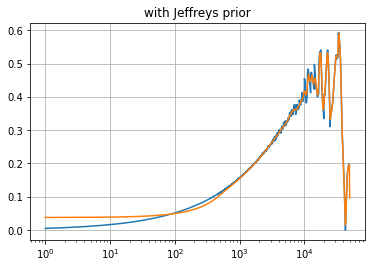

In [ ]:
plt.plot(bl_out.size_blocks, bl_out.epsilon)
plt.plot(bl_out.size_blocks, bl_out.smooth)
plt.xscale('log')
plt.title('with Jeffreys prior')
plt.grid()

print(bl_out.mean, bl_out.std, bl_out.opt_epsilon)